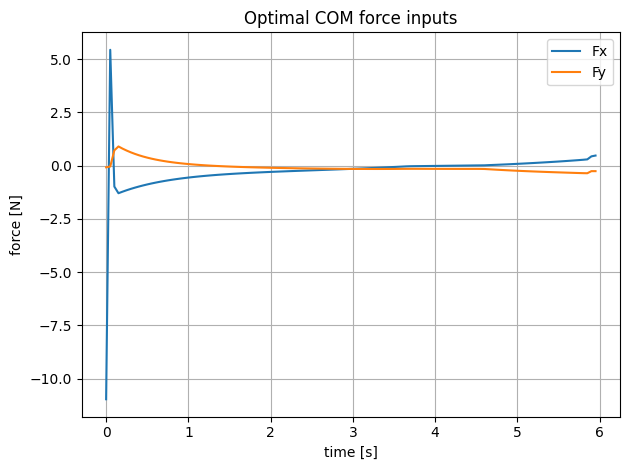

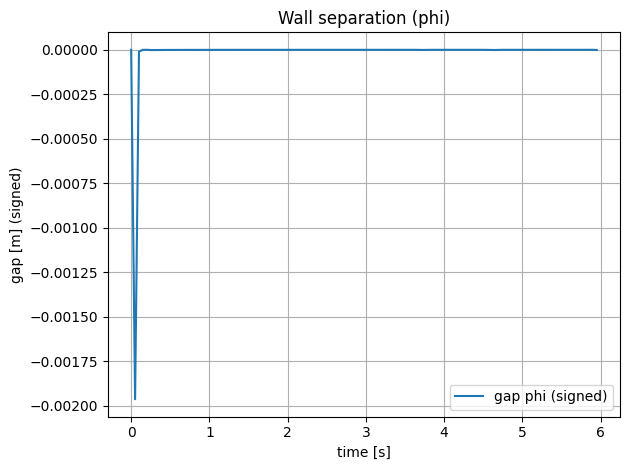

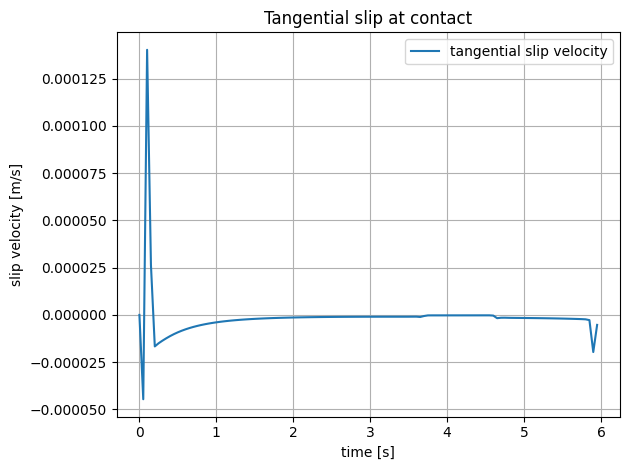

In [11]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# PARAMETERS

dt = 0.05
N = 120  # horizon length
m = 7.0  # mass [kg]
a = 0.40 # box width  [m]
b = 0.30 # box height [m]

# Use inertia about COM (coherent with v_contact = v_com + omega x r)
I_com = (m / 12.0) * (a**2 + b**2)

mu2 = 0.3        # friction coefficient with wall
u_max = 50.0     # max COM force magnitude [N]

# "Realistic contact but minimize separation/slip" tuning
w_theta = 100.0
w_v = 10.0
w_omega = 10.0

w_phi  = 1e5     # penalize separation (gap)
w_slip = 1e4     # penalize tangential slip velocity
w_u    = 1e-2    # penalize control effort

eps_comp = 1e-5  # complementarity relaxation: ln*phi <= eps

# Initial state (P = corner position in world)
p0 = np.array([0.00, 0.00]) # Initial position of corner
theta0 = 0.0
v0 = np.array([0.0, 0.0])   # COM velocity
omega0 = 0.0

# Pivoting wall: pivot point in world
p_pivot = np.array([0.0, 0.0])

# Wall rotation schedule
theta_w0 = np.pi / 2      # 90°, vertical
theta_wT = np.pi          # 180°, horizontal to the left
T = N * dt
theta_w_dot = (theta_wT - theta_w0) / T  # constant angular rate
theta_w = np.array([theta_w0 + (k*dt)*theta_w_dot for k in range(N+1)])
theta_wdot = np.array([theta_w_dot for _ in range(N+1)])  # constant

# Contact point on the box (body frame, origin at inferior-left corner)
# Middle of LEFT face is (x=0, y=b/2)
r_body = np.array([0.0, b/2.0])

# Target rotation
theta_target = theta0 + np.pi/2

# -------------------------
# OPTIMIZATION
opti = ca.Opti()

# Decision variables
X = opti.variable(6, N+1)   # [px, py, theta, vx, vy, omega]
U = opti.variable(2, N)     # [Fx, Fy] applied at COM
lam_n = opti.variable(1, N) # normal contact force magnitude
lam_t = opti.variable(1, N) # tangential contact force

# State slices
P  = X[0:2, :]     # corner position
TH = X[2, :]       # theta
V  = X[3:5, :]     # COM velocity
OM = X[5, :]       # omega

# Parameters
theta_w_param = ca.DM(theta_w)
theta_wdot_param = ca.DM(theta_wdot)
p_pivot_dm = ca.DM(p_pivot)

# Helpers
def rot2(theta):
    c = ca.cos(theta)
    s = ca.sin(theta)
    return ca.vertcat(
        ca.horzcat(c, -s),
        ca.horzcat(s,  c)
    )

def perp(v2):
    # 90-degree rotation: [x,y] -> [-y, x]
    return ca.vertcat(-v2[1], v2[0])

def wall_t_n(theta_wk):
    t = ca.vertcat(ca.cos(theta_wk), ca.sin(theta_wk))
    # normal = +90° de t (au lieu de -90°)
    n = ca.vertcat(ca.sin(theta_wk), -ca.cos(theta_wk))
    return t, n


def cross2_scalar(r2, f2):
    # scalar torque r x f in 2D
    return r2[0]*f2[1] - r2[1]*f2[0]

# -------------------------
# Initial condition constraints
opti.subject_to(P[:, 0] == p0)
opti.subject_to(TH[0] == theta0)
opti.subject_to(V[:, 0] == v0)
opti.subject_to(OM[0] == omega0)

# -------------------------
# Constraints + dynamics + running cost
J_run = 0

r_com_body = ca.DM([a/2, b/2])
r_contact_body = ca.DM(r_body)

for k in range(N):
    pk = P[:, k]
    thetak = TH[k]
    vk = V[:, k]
    omegak = OM[k]
    uk = U[:, k]
    ln = lam_n[0, k]
    lt = lam_t[0, k]

    # Wall at step k
    thw = theta_w_param[k]
    thw_dot = theta_wdot_param[k]
    t_k, n_k = wall_t_n(thw)

    # Box geometry in world
    Rk = rot2(thetak)
    r_com_world = Rk @ r_com_body
    p_com_k = pk + r_com_world

    r_c_world = Rk @ r_contact_body
    p_c = pk + r_c_world

    # Wall point velocity at p_c due to wall rotation around pivot
    r_w = p_c - p_pivot_dm
    v_w = thw_dot * perp(r_w)

    # Contact point velocity on box (using COM velocity)
    # NOTE: r_rel should be COM->contact for torque; for velocity we can use world position of contact relative to COM
    r_rel = r_c_world - r_com_world  # COM -> contact
    v_c = vk + omegak * perp(r_rel)

    # Contact force in world
    lambda_vec = ln * n_k + lt * t_k

    # -------------------------
    # Unilateral contact (allow separation, penalize it)
    # Signed gap to the wall line through pivot:
    # phi = n^T (p_c - p_pivot)  >= 0 means "on the allowed side".
    # If you notice the solver pushes to the wrong side, flip the sign: phi = -n^T(...)
    phi = n_k.T @ (p_c - p_pivot_dm)
    opti.subject_to(phi >= 0)

    # Normal force only in compression
    opti.subject_to(ln >= 0)

    # Relaxed complementarity: ln*phi <= eps
    opti.subject_to(ln * phi <= eps_comp)

    # Friction cone without fabs (Ipopt-friendly)
    opti.subject_to( lt <=  mu2 * ln)
    opti.subject_to(-lt <=  mu2 * ln)

    # Effort limit
    opti.subject_to(ca.sumsqr(uk) <= u_max**2)

    # -------------------------
    # Slip (allow, but penalize)
    v_slip = t_k.T @ (v_c - v_w)

    # -------------------------
    # Dynamics (Euler explicit)
    # theta, omega
    opti.subject_to(TH[k+1] == thetak + dt * omegak)

    # COM velocity update with control + contact
    opti.subject_to(V[:, k+1] == vk + dt * (uk + lambda_vec) / m)

    # Angular acceleration about COM from contact torque
    tau = cross2_scalar(r_rel, lambda_vec)
    opti.subject_to(OM[k+1] == omegak + dt * tau / I_com)

    # Corner position update via COM position + new rotation
    p_com_next = p_com_k + dt * vk
    R_next = rot2(TH[k+1])
    r_com_next = R_next @ r_com_body
    p_corner_next = p_com_next - r_com_next
    opti.subject_to(P[:, k+1] == p_corner_next)

    # -------------------------
    # Running cost: keep close to wall, reduce slip, regularize effort
    J_run += w_phi * (phi**2) + w_slip * (v_slip**2) + w_u * ca.sumsqr(uk)

# -------------------------
# Terminal cost
thetaN = TH[N]
vN = V[:, N]
omegaN = OM[N]
J_terminal = w_theta * (thetaN - theta_target)**2 + w_v * ca.sumsqr(vN) + w_omega * (omegaN**2)

opti.minimize(J_run + J_terminal)

# -------------------------
# Initial guess
P_init = np.tile(p0.reshape(2, 1), (1, N+1))
theta_init = np.linspace(theta0, theta_target, N+1)

direction = np.array([-1.0, 0.5])
direction = direction / np.linalg.norm(direction)
force_magnitude = 20.0
U_init = np.tile((force_magnitude * direction).reshape(2, 1), (1, N))

opti.set_initial(P, P_init)
opti.set_initial(TH, theta_init)
opti.set_initial(V, 0)
opti.set_initial(OM, 0)
opti.set_initial(U, U_init)

# Start with small contact forces (since contact is not forced anymore)
opti.set_initial(lam_n, 0.0)
opti.set_initial(lam_t, 0.0)


# -------------------------
# Solve
opts = {
    "ipopt.print_level": 0,
    "print_time": 0,
    "ipopt.max_iter": 3000,
}
opti.solver("ipopt", opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("❌ Échec :", e)
    opti.debug.show_infeasibilities()
    print("❌ Échec de la résolution :", e)
    print("🔍 Debug (k=0) :")
    print("P[0] =", opti.debug.value(P[:, 0]))
    print("TH[0] =", opti.debug.value(TH[0]))
    print("V[0] =", opti.debug.value(V[:, 0]))
    print("U[0] =", opti.debug.value(U[:, 0]))
    raise

# -------------------------
# Extract and plot controls
U_sol = sol.value(U)     # (2, N)
tgrid = np.arange(N) * dt

Fx = U_sol[0, :]
Fy = U_sol[1, :]

plt.figure()
plt.plot(tgrid, Fx, label="Fx")
plt.plot(tgrid, Fy, label="Fy")
plt.xlabel("time [s]")
plt.ylabel("force [N]")
plt.title("Optimal COM force inputs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot gap and slip to verify behavior
phi_vals = []
slip_vals = []

for k in range(N):
    thetak = sol.value(TH[k])
    pk = sol.value(P[:, k])
    vk = sol.value(V[:, k])
    omegak = sol.value(OM[k])

    thw = theta_w[k]
    thw_dot = theta_wdot[k]
    t_k = np.array([np.cos(thw), np.sin(thw)])
    n_k = np.array([-np.sin(thw), np.cos(thw)])

    Rk = np.array([[np.cos(thetak), -np.sin(thetak)],
                   [np.sin(thetak),  np.cos(thetak)]])

    r_com_world = Rk @ np.array([a/2, b/2])
    p_com_k = pk + r_com_world

    r_c_world = Rk @ np.array([0.0, b/2.0])
    p_c = pk + r_c_world

    r_rel = r_c_world - r_com_world
    v_c = vk + omegak * np.array([-r_rel[1], r_rel[0]])

    r_w = p_c - p_pivot
    v_w = thw_dot * np.array([-r_w[1], r_w[0]])

    phi_k = n_k @ (p_c - p_pivot)
    slip_k = t_k @ (v_c - v_w)

    phi_vals.append(phi_k)
    slip_vals.append(slip_k)

plt.figure()
plt.plot(tgrid, phi_vals, label="gap phi (signed)")
plt.xlabel("time [s]")
plt.ylabel("gap [m] (signed)")
plt.title("Wall separation (phi)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tgrid, slip_vals, label="tangential slip velocity")
plt.xlabel("time [s]")
plt.ylabel("slip velocity [m/s]")
plt.title("Tangential slip at contact")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
